# ** Real Time AI Traffic Mangement System Using Random Forest, SVM and GBR **

This

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
import requests
import json
import warnings
warnings.filterwarnings('ignore')

# ****

In [ ]:
# 1. Enhanced Data Generation with More Realistic Patterns
def generate_traffic_data(n_samples=1000):
    """
    Generate synthetic traffic data with more sophisticated patterns
    """
    np.random.seed(42)

    # Time features
    timestamps = [datetime.now() - timedelta(hours=x) for x in range(n_samples)]
    hours = [t.hour for t in timestamps]
    weekdays = [t.weekday() for t in timestamps]

    # Traffic patterns with rush hour effects
    base_vehicle_count = np.random.poisson(300, n_samples)
    rush_hour_effect = np.array([
        150 if (h in range(7, 10) or h in range(16, 19)) else 0
        for h in hours
    ])
    weekend_effect = np.array([-100 if w >= 5 else 0 for w in weekdays])
    vehicle_count = base_vehicle_count + rush_hour_effect + weekend_effect

    # Speed with realistic variations
    base_speed = np.random.normal(40, 10, n_samples)
    speed = np.maximum(5, np.minimum(80, base_speed - 0.05 * vehicle_count))

    # Weather with seasonal patterns
    weather = np.random.choice([0, 1, 2], n_samples, p=[0.7, 0.2, 0.1])

    # Special events with location impact
    special_events = np.random.choice([0, 1], n_samples, p=[0.9, 0.1])

    # Incident reports
    incidents = np.random.choice([0, 1], n_samples, p=[0.95, 0.05])

    # Calculate congestion with multiple factors
    congestion = np.where(
        (vehicle_count > 400) |
        ((weather != 0) & (vehicle_count > 300)) |
        (special_events == 1) |
        (incidents == 1) |
        ((base_speed < 20) & (vehicle_count > 250)),
        1, 0
    )

    return pd.DataFrame({
        'timestamp': timestamps,
        'hour': hours,
        'weekday': weekdays,
        'vehicle_count': vehicle_count,
        'average_speed': speed,
        'weather': weather,
        'special_event': special_events,
        'incident': incidents,
        'congestion': congestion
    })

In [ ]:

# 2. Advanced Data Preprocessing
def preprocess_data(data):
    """
    Enhanced data preprocessing with additional features
    """
    # Time-based features
    data['is_rush_hour'] = data['hour'].apply(
        lambda x: 1 if (x in range(7, 10) or x in range(16, 19)) else 0
    )
    data['is_weekend'] = data['weekday'].apply(
        lambda x: 1 if x >= 5 else 0
    )
    data['time_of_day'] = pd.cut(
        data['hour'],
        bins=[-1, 6, 12, 18, 24],
        labels=['night', 'morning', 'afternoon', 'evening']
    )

    # Traffic flow features
    data['vehicle_density'] = data['vehicle_count'] / 100  # vehicles per 100m
    data['congestion_index'] = (data['vehicle_count'] * (80 - data['average_speed'])) / 800

    # Weather impact features
    weather_dummies = pd.get_dummies(data['weather'], prefix='weather')
    data = pd.concat([data, weather_dummies], axis=1)

    # Scale numerical features
    scaler = StandardScaler()
    numerical_features = ['vehicle_count', 'average_speed', 'vehicle_density', 'congestion_index']
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, scaler

In [ ]:
# 3. Multiple Model Implementation
class TrafficModelEnsemble:
    def __init__(self):
        self.models = {
            'rf': RandomForestClassifier(n_estimators=100, random_state=42),
            'gb': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'nn': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
            'svm': SVC(probability=True, random_state=42)
        }
        self.best_model = None
        self.model_scores = {}

    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        """
        Train and evaluate multiple models
        """
        for name, model in self.models.items():
            # Train model
            model.fit(X_train, y_train)

            # Evaluate model
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)
            cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))

            self.model_scores[name] = {
                'train_score': train_score,
                'test_score': test_score,
                'cv_score': cv_score
            }

        # Select best model
        best_model_name = max(self.model_scores.items(),
                            key=lambda x: x[1]['cv_score'])[0]
        self.best_model = self.models[best_model_name]

        return self.model_scores

In [ ]:

# 4. Enhanced Traffic Management System
class AdvancedTrafficManagementSystem:
    def __init__(self, model_ensemble, scaler):
        self.model_ensemble = model_ensemble
        self.scaler = scaler
        self.historical_predictions = []

    def predict_congestion(self, current_data):
        """
        Predict traffic congestion using the best model
        """
        prediction = self.model_ensemble.best_model.predict(current_data)
        probability = self.model_ensemble.best_model.predict_proba(current_data)

        # Store prediction
        self.historical_predictions.append({
            'timestamp': datetime.now(),
            'prediction': prediction[0],
            'confidence': probability[0][1]
        })

        return prediction[0], probability[0]

    def analyze_patterns(self):
        """
        Analyze historical prediction patterns
        """
        if len(self.historical_predictions) > 0:
            df = pd.DataFrame(self.historical_predictions)
            return {
                'average_congestion': df['prediction'].mean(),
                'high_confidence_predictions': (df['confidence'] > 0.8).mean(),
                'trend': 'Increasing' if df['prediction'].diff().mean() > 0 else 'Decreasing'
            }
        return None

    def suggest_traffic_management(self, prediction, probability, current_data):
        """
        Enhanced traffic management suggestions
        """
        confidence = probability[1]
        suggestions = []

        if prediction == 1:
            if confidence > 0.8:
                suggestions = [
                    "⚠️ HIGH CONGESTION ALERT",
                    "Actions:",
                    "- Activate dynamic speed limits",
                    "- Implement ramp metering",
                    "- Deploy traffic personnel",
                    "- Activate alternative route suggestions",
                    f"Confidence: {confidence:.2%}"
                ]
            else:
                suggestions = [
                    "🚧 MODERATE CONGESTION WARNING",
                    "Actions:",
                    "- Monitor situation",
                    "- Prepare traffic management resources",
                    "- Update digital signage",
                    f"Confidence: {confidence:.2%}"
                ]
        else:
            suggestions = [
                "✅ NORMAL TRAFFIC FLOW",
                "Actions:",
                "- Maintain standard operations",
                "- Continue monitoring",
                f"Confidence: {1-confidence:.2%}"
            ]

        return "\n".join(suggestions)

In [ ]:

# 5. Real-time Data Integration
class TrafficDataIntegrator:
    def __init__(self, api_key=None):
        self.api_key = api_key

    def fetch_weather_data(self, lat, lon):
        """
        Fetch real weather data (example with OpenWeatherMap API)
        """
        if self.api_key:
            try:
                url = f"http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={self.api_key}"
                response = requests.get(url)
                print(response)
                print(self.api_key)
                if response.status_code == 200:
                    return response.json()
            except:
                pass
        return None

    def fetch_traffic_cameras(self, location):
        """
        Simulate traffic camera data fetch
        """
        return {
            'vehicle_count': np.random.poisson(300),
            'average_speed': max(5, np.random.normal(40, 10)),
            'timestamp': datetime.now()

        }


In [ ]:

# 6. Enhanced Visualization Functions
class TrafficVisualizer:
    def __init__(self, data):
        self.data = data

    def plot_traffic_patterns(self):
        """
        Create comprehensive traffic pattern visualizations
        """
        plt.style.use('seaborn')
        fig = plt.figure(figsize=(20, 12))

        # Plot 1: Hourly traffic patterns
        ax1 = plt.subplot(2, 3, 1)
        hourly_traffic = self.data.groupby('hour')['vehicle_count'].mean()
        hourly_traffic.plot(kind='line', ax=ax1)
        ax1.set_title('Average Vehicle Count by Hour')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Average Vehicle Count')

        # Plot 2: Weather impact
        ax2 = plt.subplot(2, 3, 2)
        weather_impact = self.data.groupby(['weather', 'time_of_day'])['congestion'].mean()
        weather_impact.unstack().plot(kind='bar', ax=ax2)
        ax2.set_title('Congestion Probability by Weather and Time')
        ax2.set_xlabel('Weather Condition')
        ax2.legend(title='Time of Day')

        # Plot 3: Speed vs Density
        ax3 = plt.subplot(2, 3, 3)
        sns.scatterplot(
            data=self.data,
            x='vehicle_density',
            y='average_speed',
            hue='congestion',
            ax=ax3
        )
        ax3.set_title('Speed-Density Relationship')

        # Plot 4: Weekly patterns
        ax4 = plt.subplot(2, 3, 4)
        weekly_pattern = self.data.groupby(['weekday', 'is_rush_hour'])['congestion'].mean()
        weekly_pattern.unstack().plot(kind='bar', ax=ax4)
        ax4.set_title('Weekly Congestion Patterns')
        ax4.set_xlabel('Day of Week')
        ax4.legend(title='Rush Hour')

        # Plot 5: Congestion heatmap
        ax5 = plt.subplot(2, 3, 5)
        pivot_data = self.data.pivot_table(
            values='congestion',
            index='hour',
            columns='weekday',
            aggfunc='mean'
        )
        sns.heatmap(pivot_data, ax=ax5, cmap='YlOrRd')
        ax5.set_title('Congestion Heatmap')
        ax5.set_xlabel('Day of Week')
        ax5.set_ylabel('Hour of Day')

        plt.tight_layout()
        return fig


Generating traffic data...
Sample value : 50000

Training multiple models...

Model Performance:

RF:
Train Score: 1.000
Test Score: 0.999
CV Score: 0.998

GB:
Train Score: 0.998
Test Score: 0.999
CV Score: 0.998

NN:
Train Score: 0.996
Test Score: 0.996
CV Score: 0.995

SVM:
Train Score: 0.958
Test Score: 0.957
CV Score: 0.953

Testing prediction system...

Traffic Management Suggestion:
✅ NORMAL TRAFFIC FLOW
Actions:
- Maintain standard operations
- Continue monitoring
Confidence: 100.00%

Generating visualizations...


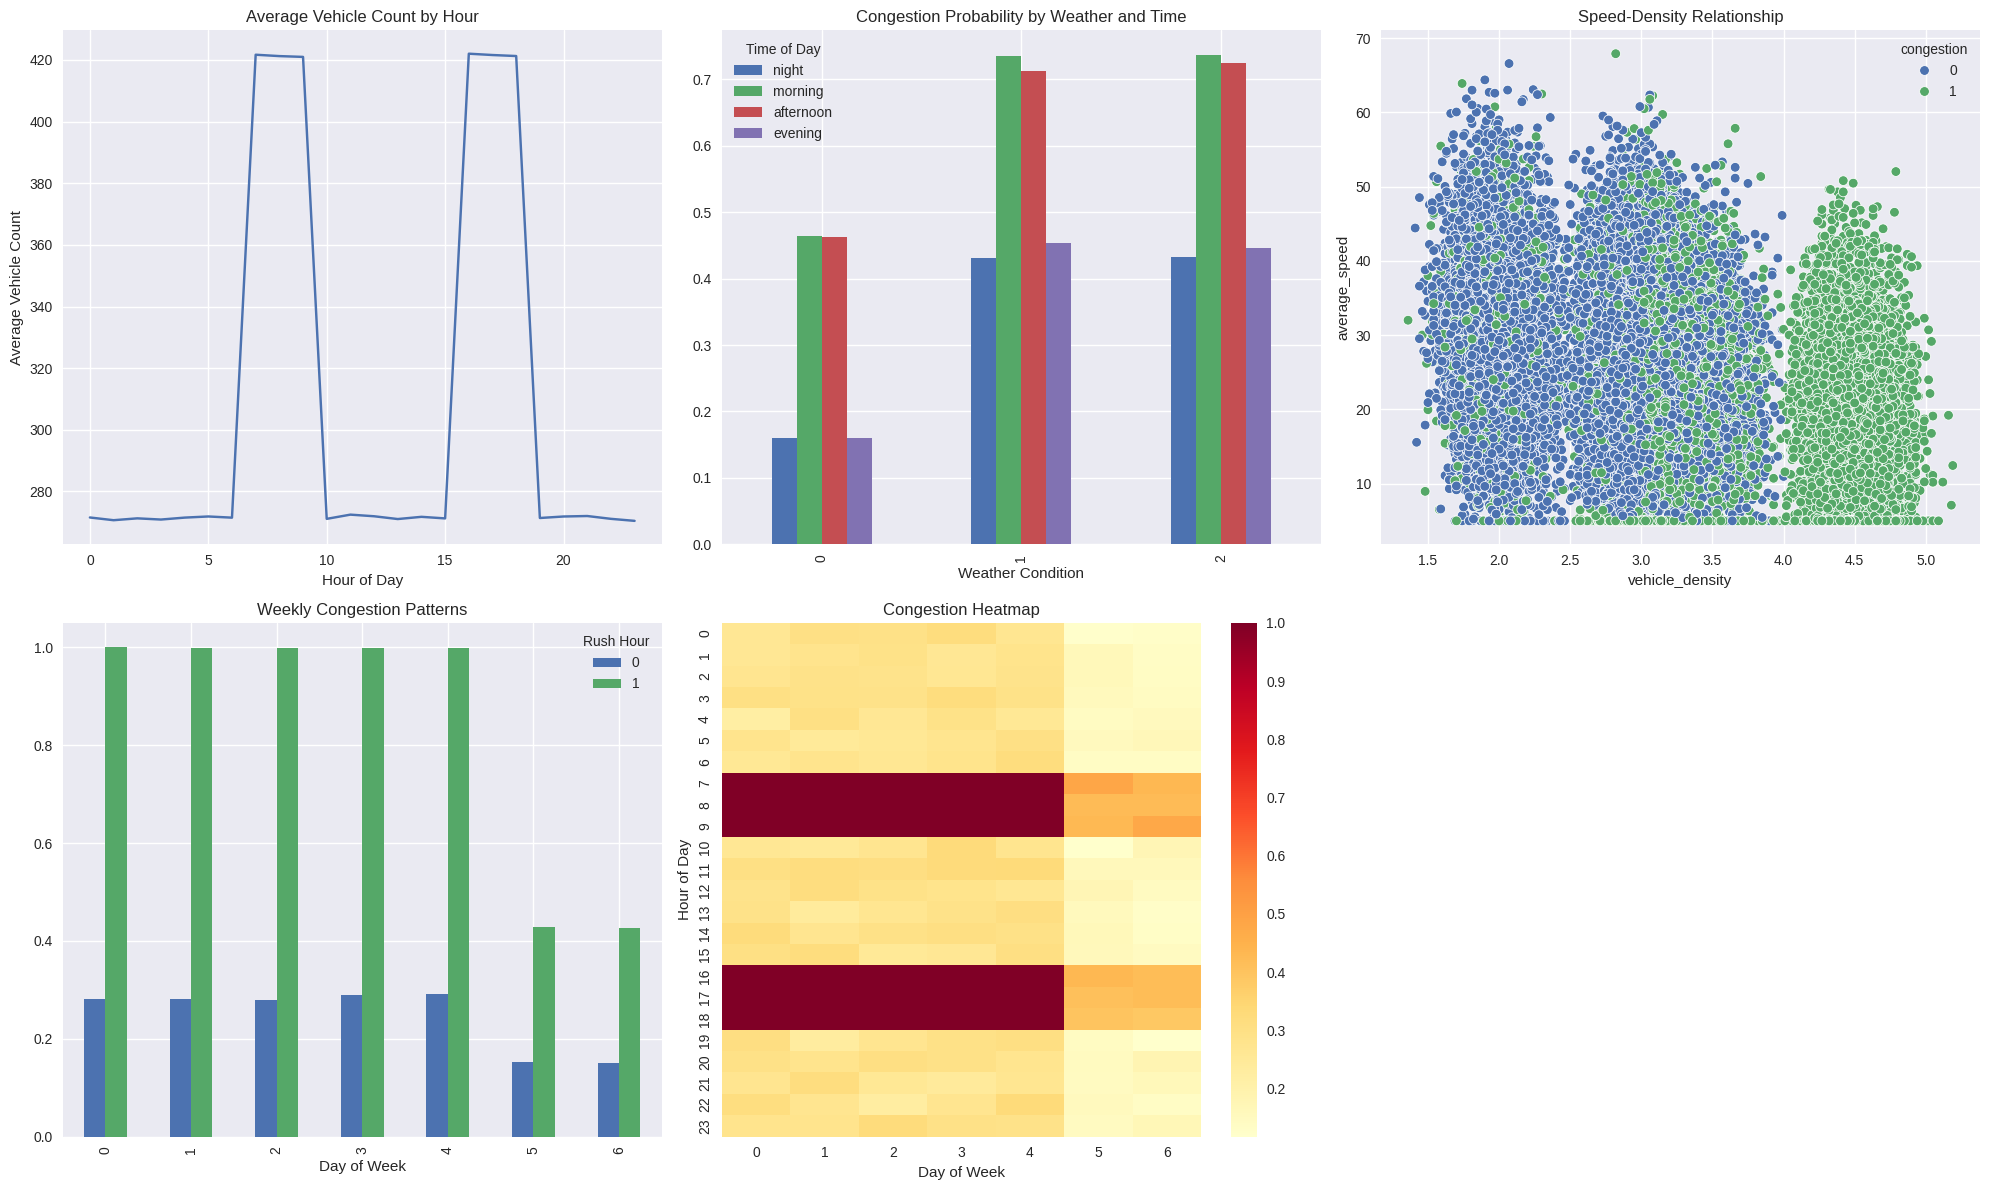


Testing real-time data integration...
Current traffic conditions: {'vehicle_count': 309, 'average_speed': 39.49313361645176, 'timestamp': datetime.datetime(2024, 10, 19, 12, 3, 21, 623063)}
Current weather conditions: None

All enhancements completed!
Thank you for using the advanced traffic management system!


In [ ]:

# Main execution with all enhancements
def main():
    # Generate and prepare data
    print("Generating traffic data...")
    sample = np.random.choice([10000,1000,5000,50000,4000])
    print (f"Sample value : {sample}")
    data = generate_traffic_data(sample)
    processed_data, scaler = preprocess_data(data)

    # Prepare features for training
    features = ['hour', 'weekday', 'vehicle_count', 'average_speed',
                'special_event', 'incident', 'is_rush_hour', 'is_weekend',
                'vehicle_density', 'congestion_index',
                'weather_0', 'weather_1', 'weather_2']

    X = processed_data[features]
    y = processed_data['congestion']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train and evaluate models
    print("\nTraining multiple models...")
    model_ensemble = TrafficModelEnsemble()
    model_scores = model_ensemble.train_and_evaluate(X_train, X_test, y_train, y_test)

    # Print model performance
    print("\nModel Performance:")
    for model_name, scores in model_scores.items():
        print(f"\n{model_name.upper()}:")
        print(f"Train Score: {scores['train_score']:.3f}")
        print(f"Test Score: {scores['test_score']:.3f}")
        print(f"CV Score: {scores['cv_score']:.3f}")

    # Create advanced traffic management system
    tms = AdvancedTrafficManagementSystem(model_ensemble, scaler)

    # Test prediction
    print("\nTesting prediction system...")
    test_data = X_test.iloc[[0]]
    prediction, probability = tms.predict_congestion(test_data)
    suggestion = tms.suggest_traffic_management(prediction, probability, test_data)
    print("\nTraffic Management Suggestion:")
    print(suggestion)

    # Create and display visualizations
    print("\nGenerating visualizations...")
    visualizer = TrafficVisualizer(data)
    fig = visualizer.plot_traffic_patterns()
    plt.show()

    # Simulate real-time data integration
    print("\nTesting real-time data integration...")
    integrator = TrafficDataIntegrator()
    current_traffic = integrator.fetch_traffic_cameras("downtown")
    print(f"Current traffic conditions: {current_traffic}")
    current_weather = integrator.fetch_weather_data(40.7128, -74.0060)
    print(f"Current weather conditions: {current_weather}")

    print("\nAll enhancements completed!")
    print("Thank you for using the advanced traffic management system!")

if __name__ == "__main__":
    main()